In [1]:
# 분석에 필요한 라이브러리 불러오기
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('./input/diabetic_data.csv', na_values='?', low_memory=False) 
# 결측치는 ?로 표시되어 있습니다.
df.tail() 

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
101761,443847548,100162476,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO
101765,443867222,175429310,Caucasian,Male,[70-80),NaN,1,1,7,6,...,No,No,No,No,No,No,No,No,No,NO


https://medium.com/@mohtedibf/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

In [2]:
# df[['diag_1','diag_2','diag_3']].replace(regex={r'^[VE][0-9]+$':100}, inplace = False) # other diag for 100
df['diag_1'].replace(regex={r'^[VE][0-9]+$':100}, inplace = True)
df['diag_2'].replace(regex={r'^[VE][0-9]+$':100}, inplace = True)
df['diag_3'].replace(regex={r'^[VE][0-9]+$':100}, inplace = True)

In [3]:
df['diag_1'] = df['diag_1'].astype(np.float64)
df['diag_2'] = df['diag_2'].astype(np.float64)
df['diag_3'] = df['diag_3'].astype(np.float64)

In [4]:
diag = ['diag_1','diag_2','diag_3']
for i in diag:
    conditions = [
        (df[i] <= 100 ),
        (df[i] >= 140 ) & (df[i] < 240),
        (df[i] >= 250 ) & (df[i] < 251),
        (df[i] >= 390 ) & (df[i] < 460),
        (df[i] >= 460 ) & (df[i] < 520),
        (df[i] >= 520 ) & (df[i] < 580),
        (df[i] >= 580 ) & (df[i] < 630),
        (df[i] >= 710 ) & (df[i] < 740),
        (df[i] >= 800 ) & (df[i] < 1000),        
        (df[i] == 785),
        (df[i] == 786),
        (df[i] == 787),
        (df[i] == 788)]
    choices = ['other','neoplasms','diabetes','circulatory','respiratory','digestive',
               'genitourinanry','musculoskeletal','injury','circulatory','respiratory','digestive','genitourinanry']
    df[i] = np.select(conditions, choices)

In [5]:
df['age'].replace({ '[0-10)':5, '[10-20)':15, 
                     '[20-30)':25, '[30-40)':35, 
                     '[40-50)':45, '[50-60)':55, 
                     '[60-70)':65, '[70-80)':75,
                     '[80-90)':85, '[90-100)':95}, inplace = True)

df['max_glu_serum'].replace({'None':0,'Norm':1,
                             '>200': 2, '>300':3}, inplace = True)

df['A1Cresult'].replace({'None':0, 'Norm':1,
                        '>7':2, '>8':3}, inplace = True)

df['change'].replace({'No':0, 'Ch':1}, inplace = True)

df['diabetesMed'].replace({'No':0, 'Yes':1}, inplace = True)

medications = ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride",
               "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone",
               "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", 
               "examide", "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin", 
               "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"]
for i in medications:
    df[i].replace({'No': -1,'Down': 0,'Steady': 1,'Up': 2}, inplace = True)


categoricals = ['race','gender', 'payer_code', 'medical_specialty','diag_1', 'diag_2', 'diag_3']
for j in categoricals:
    df[j] = pd.Categorical(df[j]).codes #  integer 값으로 바꿔 줍니다.
    df[j].astype('int64')
    
df['readmitted'].replace({'NO':0, '>30':1, '<30':1}, inplace = True)
# 쓸모 없어 보이는 데이터 삭제
del_columns = ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "weight",
               "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone",
               "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", 
               "examide", "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin", 
               "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone","number_emergency", "max_glu_serum","number_inpatient"] # 삭제할 데이터
df.drop(del_columns, inplace=True, axis=1)


In [6]:
conditions = [
    (df['age'] <= 5 ),
    (df['age'] >= 15 ) & (df['age'] < 25),
    (df['age'] >= 25 ) & (df['age'] < 65),
    (df['age'] >= 65 ) & (df['age'] < 95),
    (df['age'] >= 95)]
choices = [0, 1, 2, 3, 4]
df['age'] = np.select(conditions, choices)

In [7]:
conditions = [(df['number_diagnoses'] <= 1 ),
    (df['number_diagnoses'] >= 2 ) & (df['number_diagnoses'] < 6),
    (df['number_diagnoses'] >= 6 ) & (df['number_diagnoses'] < 9),
    (df['number_diagnoses'] >= 9 )]
choices = [0, 1, 2, 3]
df['number_diagnoses'] = np.select(conditions, choices)

In [8]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,num_medications,number_outpatient,diag_1,diag_2,diag_3,number_diagnoses,A1Cresult,change,diabetesMed,readmitted
0,2278392,8222157,2,0,0,6,25,1,1,-1,...,1,0,2,0,0,0,0,0,0,0
1,149190,55629189,2,0,1,1,1,7,3,-1,...,18,0,0,2,0,3,0,1,1,1
2,64410,86047875,0,0,2,1,1,7,2,-1,...,13,2,0,2,8,2,0,0,1,0
3,500364,82442376,2,1,2,1,1,7,2,-1,...,16,0,8,2,1,2,0,1,1,0
4,16680,42519267,2,1,2,1,1,7,1,-1,...,8,0,7,7,2,1,0,1,1,0


스케일링하기

In [9]:
labels = df.readmitted # label
train = df.drop(['encounter_id', 'patient_nbr','readmitted'], axis=1) # label과 고유값을 제거

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.25)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(76324, 20) (76324,)
(25442, 20) (25442,)


데이터셋 나누고
랜덤 포레스트 다시 한번

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [11]:
y_pred = rf.predict(x_test)
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.56461302430523563

In [19]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

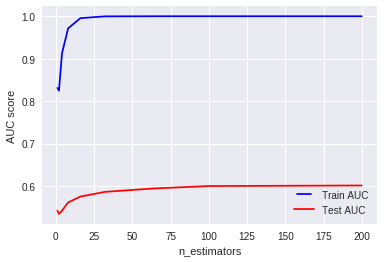

In [20]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

In [23]:
max_depths = np.linspace(1, 100, 100, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    

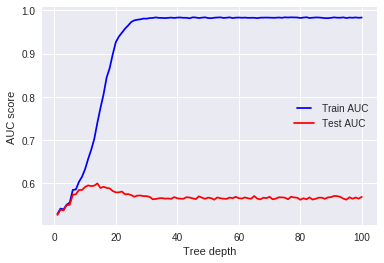

In [25]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

We see that our model overfits for large depth values. The tree perfectly predicts all of the train data, however, it fails to generalize the findings for new data
# min_samples_split
min_samples_split represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node. Here we will vary the parameter from 10% to 100% of the samples

In [29]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split=min_samples_split, max_depth = 15, n_estimators = 25)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)    

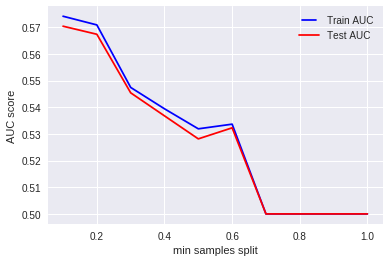

In [30]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

We can clearly see that when we require all of the samples at each node, the model cannot learn enough about the data. This is an underfitting case.

# min_samples_leaf
min_samples_leaf is The minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs, the base of the tree.

In [31]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, min_samples_split=0.1, max_depth = 15, n_estimators = 25)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    

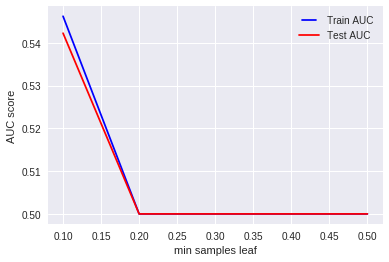

In [33]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

Same conclusion as to previous parameter. Increasing this value can cause underfitting.
# max_features
max_features represents the number of features to consider when looking for the best split.

In [40]:
max_features = list(range(1,train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    rf = RandomForestClassifier(max_features=max_feature,
                               min_samples_leaf=0.1, min_samples_split=0.1, max_depth = 15, n_estimators = 25)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

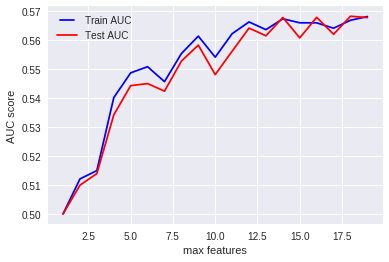

In [41]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()